In [3]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from PIL import ImageFile

2024-10-15 12:57:10.016154: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# remove dodgy images
import cv2
import imghdr

In [6]:
data_dir = 'data'

image_exts = ['jpeg', 'jpg', 'png','bmp', 'gif']

In [7]:
# removing images that are not of image format and which tensorflow cannot process
for image_class in os.listdir(data_dir) :
    for image in os.listdir(os.path.join(data_dir, image_class)) :
        image_path = os.path.join(data_dir, image_class, image)
        if image.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):   
            try :
                # Check if the image extension is valid
                img_type = imghdr.what(image_path)
                if img_type not in image_exts:
                    print(f"Image not in allowed extensions list, removing: {image_path}")
                    os.remove(image_path)
                    continue

                # Attempt to open the image with OpenCV and Pillow to catch any corrupted files
                img = cv2.imread(image_path)
                if img is None:
                    print(f"Corrupted image detected and removed: {image_path}")
                    os.remove(image_path)
                    continue

                with Image.open(image_path) as img:
                    img.verify()  # Verify that it is indeed an image
                 # Check if TensorFlow can decode the image
                raw_img = tf.io.read_file(image_path)
                _ = tf.image.decode_jpeg(raw_img)
            except Exception as e:
                print(f"Removing corrupted or unreadable image: {image} - Error: {e}")
                os.remove(image_path)

libpng warning: iCCP: known incorrect sRGB profile
2024-10-15 12:58:17.474724: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


In [ ]:
# Load dataset
tf.data.Dataset
data = tf.keras.utils.image_dataset_from_directory('data')

Found 1988 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [ ]:
print(batch[0].shape)

(32, 256, 256, 3)


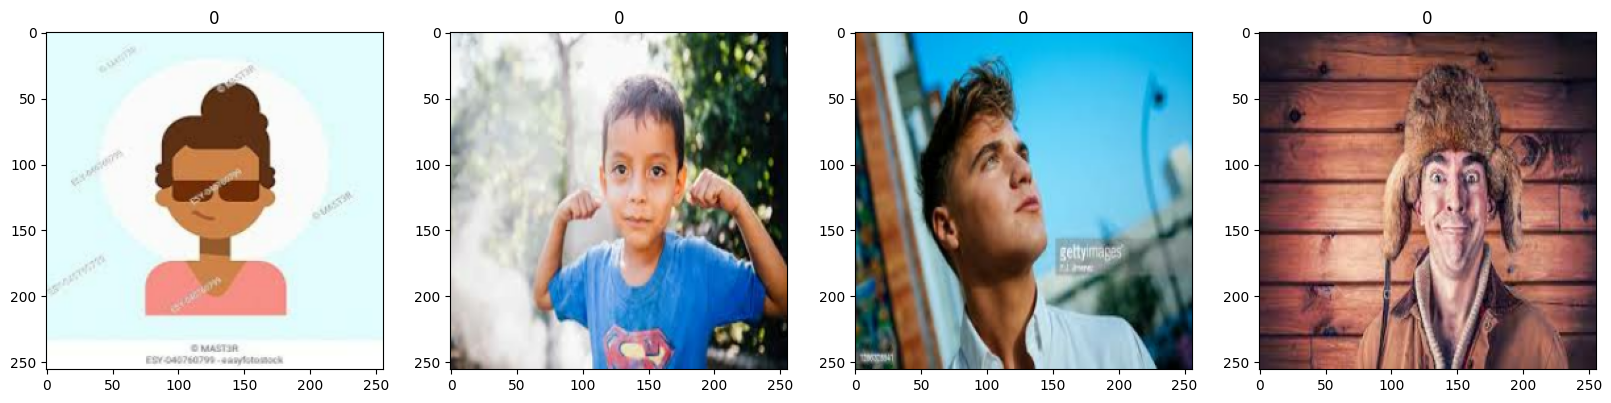

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]) :
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
batch = data_iterator.next()

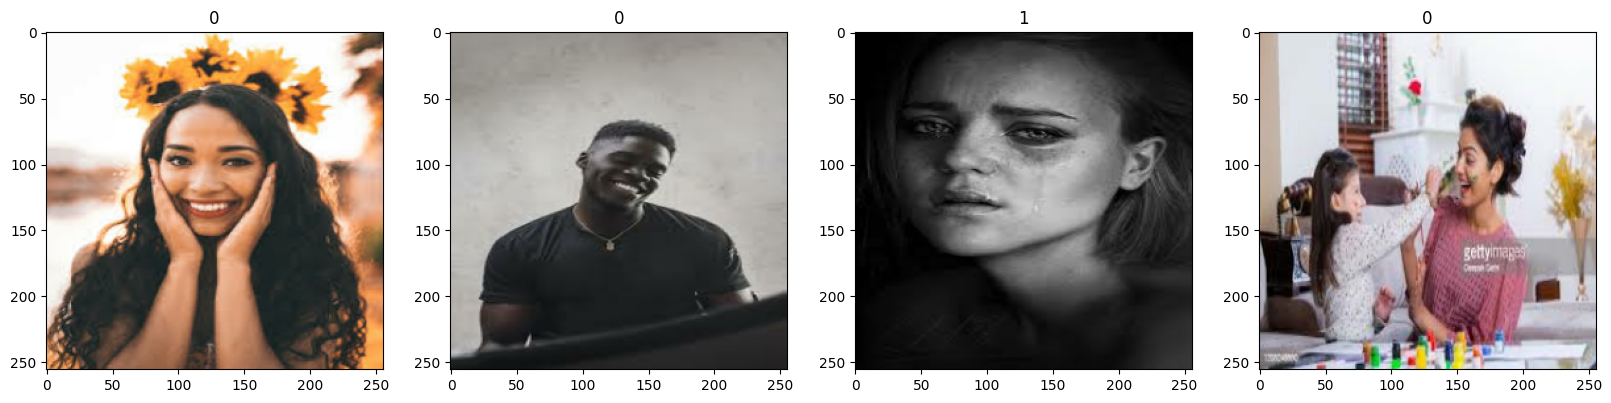

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]) :
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
# Pre-processing in the pipeline
scaled_data = data.map(lambda x,y : (x/255, y))
scaled_iter = scaled_data.as_numpy_iterator()
print(scaled_iter.next()[0].max())

1.0


In [ ]:
train_size = int(len(scaled_data)*.7)
validate_size = int(len(scaled_data)*.2)+1
test_size = int(len(scaled_data)*.1)+1

print(train_size + validate_size + test_size)

train = scaled_data.take(train_size)
validate = scaled_data.skip(train_size).take(validate_size)
test = scaled_data.skip(train_size + validate_size).take(test_size)

64


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential([
    Conv2D(16,(3,3),1, activation='relu', input_shape=(256,256,3)),
    MaxPooling2D(),
    Conv2D(32,(3,3), 1, activation='relu'),
    MaxPooling2D(),
    Conv2D(16,(3,3), 1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
    ])

/Users/Sylar/Desktop/Projects/cpe593/image_classification/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# compile
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs = 20, validation_data = validate, callbacks = [tensorboard_callback])

Epoch 1/20
29/44 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.4969 - loss: 1.3023

2024-10-15 11:31:46.656489: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5000 - loss: 1.1621

2024-10-15 11:32:20.609830: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.5002 - loss: 1.1553 - val_accuracy: 0.4880 - val_loss: 0.6967
Epoch 2/20
42/44 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5710 - loss: 0.6822

2024-10-15 11:33:38.752356: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5714 - loss: 0.6817

2024-10-15 11:34:11.959410: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.5716 - loss: 0.6814 - val_accuracy: 0.6442 - val_loss: 0.6246
Epoch 3/20
35/44 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.5850 - loss: 0.6570

2024-10-15 11:36:58.670247: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5912 - loss: 0.6545

2024-10-15 11:38:48.337488: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 264s 6s/step - accuracy: 0.5919 - loss: 0.6541 - val_accuracy: 0.5745 - val_loss: 0.8929
Epoch 4/20
37/44 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6277 - loss: 0.6600

2024-10-15 11:40:13.126215: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6302 - loss: 0.6553

2024-10-15 11:40:40.057682: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.6303 - loss: 0.6549 - val_accuracy: 0.6082 - val_loss: 0.6323
Epoch 5/20
30/44 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7165 - loss: 0.5903

2024-10-15 11:42:18.530722: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7133 - loss: 0.5860

2024-10-15 11:42:53.184654: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.7132 - loss: 0.5857 - val_accuracy: 0.6659 - val_loss: 0.6103
Epoch 6/20
35/44 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7243 - loss: 0.5247

2024-10-15 11:44:04.510452: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7261 - loss: 0.5217

2024-10-15 11:44:29.482226: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7262 - loss: 0.5216 - val_accuracy: 0.6707 - val_loss: 0.6198
Epoch 7/20
34/44 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8023 - loss: 0.4281

2024-10-15 11:46:32.472657: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8023 - loss: 0.4264

2024-10-15 11:47:12.863897: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.8023 - loss: 0.4265 - val_accuracy: 0.6490 - val_loss: 0.6391
Epoch 8/20
30/44 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8428 - loss: 0.3610

2024-10-15 11:48:18.973295: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8450 - loss: 0.3514

2024-10-15 11:49:03.503255: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.8450 - loss: 0.3510 - val_accuracy: 0.6899 - val_loss: 0.6852
Epoch 9/20
30/44 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8935 - loss: 0.2604

2024-10-15 11:50:10.147850: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8987 - loss: 0.2511

2024-10-15 11:50:39.538505: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8989 - loss: 0.2506 - val_accuracy: 0.7212 - val_loss: 0.8455
Epoch 10/20
30/44 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9354 - loss: 0.1822

2024-10-15 11:52:10.763776: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9379 - loss: 0.1752

2024-10-15 11:52:41.110526: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9378 - loss: 0.1753 - val_accuracy: 0.7212 - val_loss: 0.9349
Epoch 11/20
27/44 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9781 - loss: 0.1144

2024-10-15 11:53:39.505065: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9751 - loss: 0.1157

2024-10-15 11:54:18.032844: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9747 - loss: 0.1162 - val_accuracy: 0.7308 - val_loss: 0.8042
Epoch 12/20
31/44 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9589 - loss: 0.1378

2024-10-15 11:55:30.067332: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9626 - loss: 0.1269

2024-10-15 11:55:55.080309: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9627 - loss: 0.1265 - val_accuracy: 0.7548 - val_loss: 1.1110
Epoch 13/20
37/44 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9578 - loss: 0.1203

2024-10-15 11:57:14.246901: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9603 - loss: 0.1170

2024-10-15 11:57:33.425946: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9605 - loss: 0.1167 - val_accuracy: 0.7380 - val_loss: 1.2473
Epoch 14/20
41/44 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9904 - loss: 0.0418

2024-10-15 11:59:16.203496: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9905 - loss: 0.0421

2024-10-15 11:59:24.593667: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.9905 - loss: 0.0423 - val_accuracy: 0.7572 - val_loss: 1.1204
Epoch 15/20
38/44 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9876 - loss: 0.0383

2024-10-15 12:00:38.366277: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9873 - loss: 0.0396

2024-10-15 12:00:50.140159: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9872 - loss: 0.0399 - val_accuracy: 0.7452 - val_loss: 1.1469
Epoch 16/20
29/44 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9924 - loss: 0.0348

2024-10-15 12:01:39.241098: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9924 - loss: 0.0341

2024-10-15 12:02:05.532536: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9923 - loss: 0.0343 - val_accuracy: 0.7596 - val_loss: 1.1281
Epoch 17/20
29/44 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9918 - loss: 0.0466

2024-10-15 12:02:55.211769: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9922 - loss: 0.0482

2024-10-15 12:03:32.439130: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9922 - loss: 0.0483 - val_accuracy: 0.7596 - val_loss: 1.2568
Epoch 18/20
32/44 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9935 - loss: 0.0211

2024-10-15 12:05:14.712665: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9934 - loss: 0.0267

2024-10-15 12:05:33.655795: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9934 - loss: 0.0274 - val_accuracy: 0.7764 - val_loss: 1.0631
Epoch 19/20
39/44 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9956 - loss: 0.0379

2024-10-15 12:06:48.520601: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9953 - loss: 0.0390

2024-10-15 12:07:06.073536: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9952 - loss: 0.0396 - val_accuracy: 0.7668 - val_loss: 1.1111
Epoch 20/20
36/44 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9931 - loss: 0.0525

2024-10-15 12:08:22.324528: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9934 - loss: 0.0519

2024-10-15 12:08:39.592507: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/44 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9934 - loss: 0.0520 - val_accuracy: 0.7837 - val_loss: 1.0457


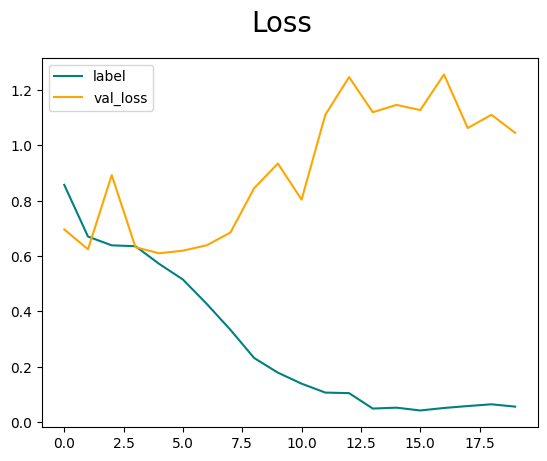

In [ ]:
# loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='label')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

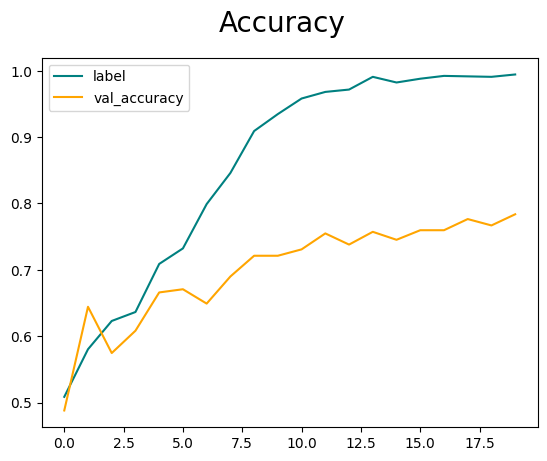

In [ ]:
# accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='label')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# evaluate
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

2024-10-15 12:13:34.078881: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


2024-10-15 12:13:44.428369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


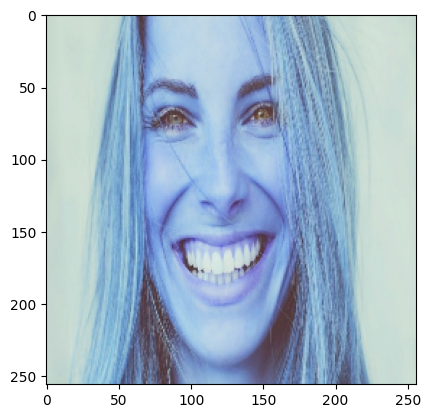

In [ ]:
img = cv2.imread("test_img_1.jpg")
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


In [ ]:
yhat

array([[0.2265689]], dtype=float32)